In [1]:
! nvidia-smi

Thu Feb  9 20:17:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   56C    P3   134W / 350W |   1759MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   

In [2]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [6]:
trainset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

valset = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)

testset = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
trainset.__len__(), valset.__len__(), testset.__len__()

(1020, 1020, 6149)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


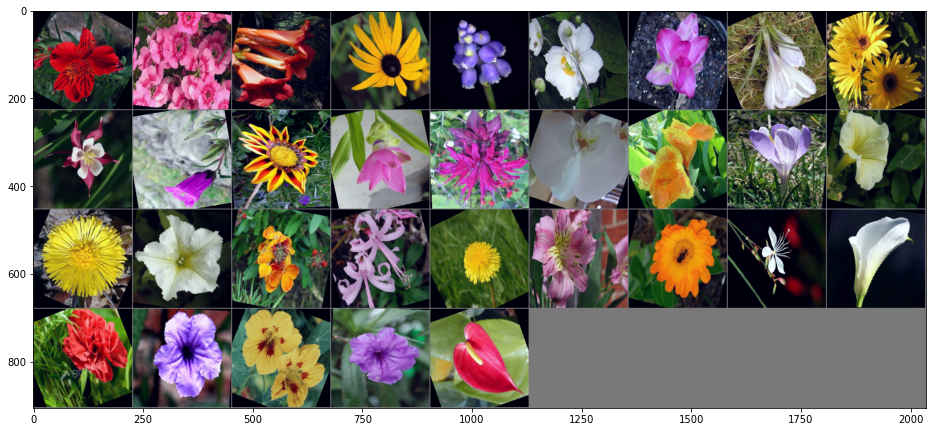

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [9]:
# print labels
for i in range(batch_size//nrow + 1 if batch_size % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

17  29  100 62  24  61  38  66  40 
83  2   70  38  91  6   89  66  50 
11  50  45  36  49  17  4   56  19 
30  97  88  97  79 


In [10]:
import torch.nn as nn
import torch.nn.functional as F

#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)

model_ft = torchvision.models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
half_in_size = round(num_ftrs/2)
layer_width = 102
Num_class=102

Multilayer_fc = nn.Sequential(
            nn.Linear(num_ftrs, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, Num_class)
        )

model_ft.fc = Multilayer_fc

net = model_ft.to(device)

In [11]:
from torchsummary import summary
summary(net, (3, 224, 224), batch_size = 32)
#from torchinfo import summary as summary_info
#summary_info(net, input_size = (128, 3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5          [32, 128, 56, 56]           8,192
       BatchNorm2d-6          [32, 128, 56, 56]             256
              ReLU-7          [32, 128, 56, 56]               0
            Conv2d-8          [32, 128, 56, 56]           4,608
       BatchNorm2d-9          [32, 128, 56, 56]             256
             ReLU-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          32,768
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

In [12]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [13]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 40

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 4.611, acc: 1.471%, f1-score: 0.7109%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 4.526, acc: 7.255%, f1-score: 5.966%, support: 1020
epoch 2 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 4.204, acc: 11.57%, f1-score: 8.065%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 3.358, acc: 14.71%, f1-score: 8.814%, support: 1020
epoch 3 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 2.96, acc: 26.47%, f1-score: 22.65%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 2.725, acc: 30.49%, f1-score: 23.91%, support: 1020
epoch 4 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 2.05, acc: 44.9%, f1-score: 43.22%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 2.579, acc: 36.18%, f1-score: 32.03%, support: 1020
epoch 5 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 1.749, acc: 52.06%, f1-score: 50.65%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 3.251, acc: 32.16%, f1-score: 27.74%, support: 1020
epoch 6 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 1.709, acc: 52.84%, f1-score: 51.69%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 2.96, acc: 42.55%, f1-score: 38.88%, support: 1020
epoch 7 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 1.631, acc: 56.08%, f1-score: 55.07%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 2.244, acc: 46.47%, f1-score: 42.54%, support: 1020
epoch 8 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.8228, acc: 76.86%, f1-score: 75.96%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.191, acc: 69.22%, f1-score: 67.22%, support: 1020
epoch 9 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.5046, acc: 84.22%, f1-score: 84.07%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.28, acc: 69.71%, f1-score: 68.03%, support: 1020
epoch 10 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.3829, acc: 86.18%, f1-score: 86.11%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.9391, acc: 75.78%, f1-score: 75.14%, support: 1020
epoch 11 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.2621, acc: 91.76%, f1-score: 91.74%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.021, acc: 76.86%, f1-score: 76.99%, support: 1020
epoch 12 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.2487, acc: 91.57%, f1-score: 91.5%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.06, acc: 75.0%, f1-score: 74.72%, support: 1020
epoch 13 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.2101, acc: 92.75%, f1-score: 92.67%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.262, acc: 73.92%, f1-score: 73.86%, support: 1020
epoch 14 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.1949, acc: 94.02%, f1-score: 94.07%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 1.078, acc: 75.69%, f1-score: 74.82%, support: 1020
epoch 15 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.1006, acc: 97.84%, f1-score: 97.84%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.7625, acc: 81.76%, f1-score: 81.73%, support: 1020
epoch 16 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.05278, acc: 98.53%, f1-score: 98.52%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.7076, acc: 82.06%, f1-score: 81.97%, support: 1020
epoch 17 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.04054, acc: 99.02%, f1-score: 99.01%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.667, acc: 84.12%, f1-score: 84.34%, support: 1020
epoch 18 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.023, acc: 99.61%, f1-score: 99.61%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6591, acc: 85.29%, f1-score: 85.39%, support: 1020
epoch 19 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01847, acc: 99.71%, f1-score: 99.71%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6442, acc: 85.2%, f1-score: 85.21%, support: 1020
epoch 20 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01807, acc: 99.51%, f1-score: 99.51%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6496, acc: 85.1%, f1-score: 85.09%, support: 1020
epoch 21 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.0142, acc: 99.8%, f1-score: 99.8%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.634, acc: 86.37%, f1-score: 86.42%, support: 1020
epoch 22 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01086, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6196, acc: 87.16%, f1-score: 87.15%, support: 1020
epoch 23 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01379, acc: 99.61%, f1-score: 99.61%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6206, acc: 86.86%, f1-score: 86.82%, support: 1020
epoch 24 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.007841, acc: 99.8%, f1-score: 99.8%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6073, acc: 86.47%, f1-score: 86.41%, support: 1020
epoch 25 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.009643, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6009, acc: 87.16%, f1-score: 87.17%, support: 1020
epoch 26 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.007645, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6093, acc: 86.86%, f1-score: 86.8%, support: 1020
epoch 27 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01067, acc: 99.8%, f1-score: 99.8%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6392, acc: 86.96%, f1-score: 86.87%, support: 1020
epoch 28 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.01122, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6193, acc: 86.76%, f1-score: 86.67%, support: 1020
epoch 29 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.005179, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6047, acc: 86.76%, f1-score: 86.71%, support: 1020
epoch 30 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.008559, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6195, acc: 87.16%, f1-score: 87.01%, support: 1020
epoch 31 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.006084, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6184, acc: 86.76%, f1-score: 86.6%, support: 1020
epoch 32 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.003585, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6091, acc: 86.86%, f1-score: 86.66%, support: 1020
epoch 33 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.003743, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6283, acc: 86.86%, f1-score: 86.74%, support: 1020
epoch 34 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.004009, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6097, acc: 87.25%, f1-score: 87.17%, support: 1020
epoch 35 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.004649, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6119, acc: 86.27%, f1-score: 86.2%, support: 1020
epoch 36 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.005221, acc: 99.8%, f1-score: 99.8%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.5987, acc: 87.25%, f1-score: 87.14%, support: 1020
epoch 37 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.005164, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6081, acc: 87.25%, f1-score: 87.15%, support: 1020
epoch 38 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.004997, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.5928, acc: 86.96%, f1-score: 86.74%, support: 1020
epoch 39 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.005876, acc: 99.9%, f1-score: 99.9%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.6004, acc: 87.45%, f1-score: 87.34%, support: 1020
epoch 40 
Training ...


  0%|          | 0/32 [00:00<?, ?it/s]

training loss: 0.004589, acc: 100.0%, f1-score: 100.0%, support: 1020
validating ...


  0%|          | 0/32 [00:00<?, ?it/s]

validation loss: 0.5878, acc: 87.55%, f1-score: 87.38%, support: 1020
Finished Training


In [14]:
min_val_loss

0.5877502341754735

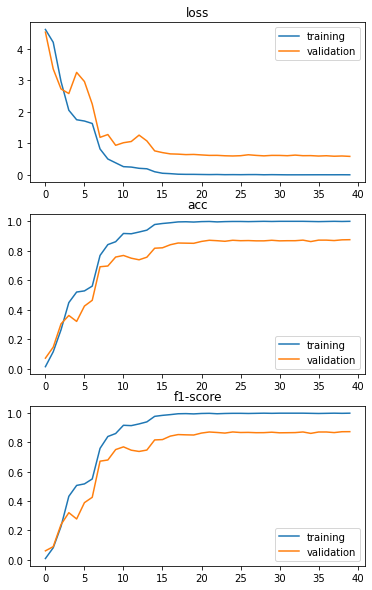

In [15]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [16]:
PATH = './Flowers102-resnext50.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/193 [00:00<?, ?it/s]

testing loss: 0.6965
              precision    recall  f1-score   support

           0     0.4444    0.8000    0.5714        20
           1     0.9730    0.9000    0.9351        40
           2     0.3571    0.7500    0.4839        20
           3     0.4483    0.3611    0.4000        36
           4     0.8222    0.8222    0.8222        45
           5     0.9167    0.8800    0.8980        25
           6     0.6061    1.0000    0.7547        20
           7     0.9028    1.0000    0.9489        65
           8     0.7742    0.9231    0.8421        26
           9     0.8621    1.0000    0.9259        25
          10     0.8163    0.5970    0.6897        67
          11     0.9118    0.9254    0.9185        67
          12     0.8125    0.8966    0.8525        29
          13     0.8438    0.9643    0.9000        28
          14     0.7027    0.8966    0.7879        29
          15     0.4324    0.7619    0.5517        21
          16     1.0000    0.9077    0.9516        65
      

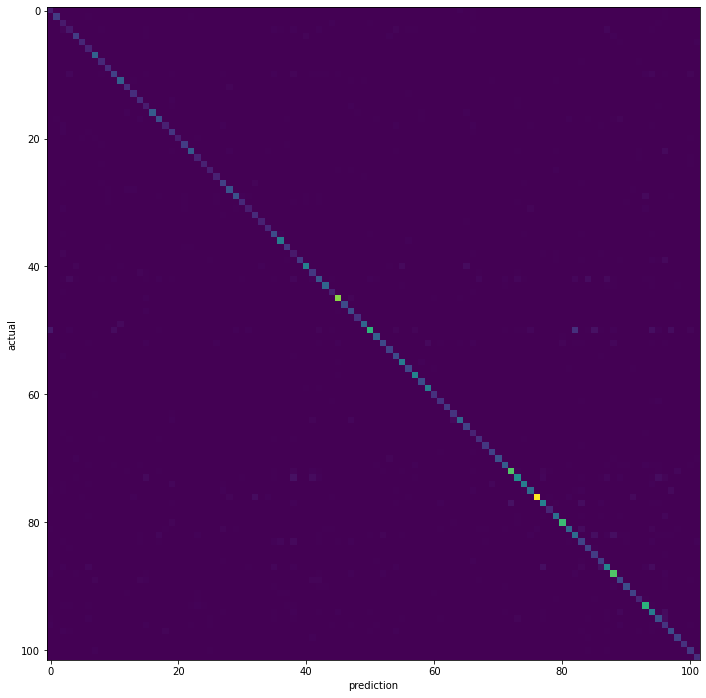

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(M)
ax.set_xlabel("prediction")
ax.set_ylabel("actual")
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(trainloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/32 [00:00<?, ?it/s]

testing loss: 0.0004901
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    1.0000    1.0000        10
           2     1.0000    1.0000    1.0000        10
           3     1.0000    1.0000    1.0000        10
           4     1.0000    1.0000    1.0000        10
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000        10
           7     1.0000    1.0000    1.0000        10
           8     1.0000    1.0000    1.0000        10
           9     1.0000    1.0000    1.0000        10
          10     1.0000    1.0000    1.0000        10
          11     1.0000    1.0000    1.0000        10
          12     1.0000    1.0000    1.0000        10
          13     1.0000    1.0000    1.0000        10
          14     1.0000    1.0000    1.0000        10
          15     1.0000    1.0000    1.0000        10
          16     1.0000    1.0000    1.0000        10
   

In [20]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(valloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/32 [00:00<?, ?it/s]

testing loss: 0.5878
              precision    recall  f1-score   support

           0     0.9000    0.9000    0.9000        10
           1     1.0000    0.9000    0.9474        10
           2     0.6667    0.8000    0.7273        10
           3     0.4286    0.3000    0.3529        10
           4     0.8333    1.0000    0.9091        10
           5     1.0000    1.0000    1.0000        10
           6     0.9091    1.0000    0.9524        10
           7     0.7692    1.0000    0.8696        10
           8     0.6364    0.7000    0.6667        10
           9     1.0000    1.0000    1.0000        10
          10     0.7778    0.7000    0.7368        10
          11     0.9091    1.0000    0.9524        10
          12     0.9091    1.0000    0.9524        10
          13     1.0000    1.0000    1.0000        10
          14     0.9091    1.0000    0.9524        10
          15     0.7500    0.9000    0.8182        10
          16     1.0000    1.0000    1.0000        10
      